**DETECT MEDICAL DATA ABNORMALITIES USING AUTOENCODERS**

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# Generate normal simulated medical data
np.random.seed(42)
num_pacientes = 700
data = {
    "patient_id": [f"P{str(i).zfill(3)}" for i in range(num_pacientes)],
    "heart_rate": np.random.normal(75, 10, num_pacientes),  # BPM
    "spo2": np.random.normal(97, 2, num_pacientes),         # % oxígeno
    "temperature": np.random.normal(36.6, 0.5, num_pacientes), # °C
    "glucose": np.random.normal(90, 15, num_pacientes),        # mg/dL
}

# Convert into a dataframe before adding abnormalities
df_medical = pd.DataFrame(data)

# Create a column to identify normal data from abnormalities
df_medical["label"] = 0

for i in range(200):
    idx = np.random.randint(0, num_pacientes)

    # Select values from risky ranges
    df_medical.loc[idx, "heart_rate"] = np.random.choice([
        np.random.randint(40, 60),
        np.random.randint(160, 200)
    ])
    df_medical.loc[idx, "spo2"] = np.random.choice([
        np.random.randint(30, 40),
        np.random.randint(90, 96)
    ])
    df_medical.loc[idx, "temperature"] = np.random.choice([
        np.random.uniform(34, 36),
        np.random.uniform(39, 42)
    ])
    df_medical.loc[idx, "glucose"] = np.random.choice([
        np.random.randint(50, 70),
        np.random.randint(250, 320)
    ])
    df_medical.loc[idx, "label"] = 1

# Normalize data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_medical.iloc[:, 1:-1]), columns=df_medical.columns[1:-1])

# Split data
df_train, df_test, y_train, y_test = train_test_split(df_scaled, df_medical["label"], test_size=0.2, random_state=42)
df_train = df_train[y_train == 0]  # Use only normal data


In [4]:
# Create Autoencoder
input_dim = df_train.shape[1]

autoencoder = keras.Sequential([
    keras.layers.Dense(128, activation="relu", input_shape=(input_dim,)),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dropout(0.2),  # Dropout to avoid overfitting
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(input_dim, activation="sigmoid")  # Rebuild data
])

autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.fit(df_train, df_train, epochs=100, batch_size=16, shuffle=True, verbose=0)

# Evaluate reconstruction errors
reconstructions_test = autoencoder.predict(df_test)
mse_test = np.mean(np.power(df_test - reconstructions_test, 2), axis=1)

# Adjust the optimal threshold using the roc curve
fpr, tpr, thresholds = roc_curve(y_test, mse_test)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]*1.2

df_medical["autoencoder_anomaly"] = 0
df_medical.loc[df_test.index, "autoencoder_anomaly"] = (mse_test > optimal_threshold).astype(int) # Apply the optimal threshold


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


📊 PRECISIÓN DEL MODELO:
✔ Precisión: 1.00
✔ Recall (Sensibilidad): 0.95
✔ F1-score: 0.97
✔ ROC-AUC: 1.00


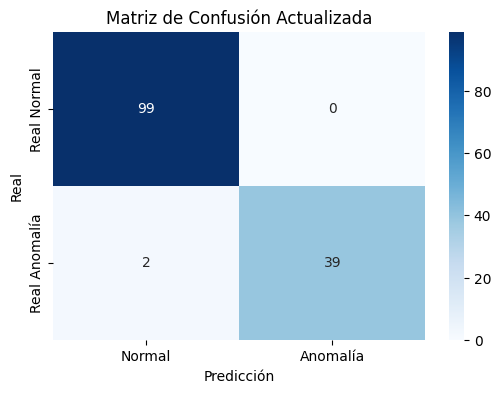

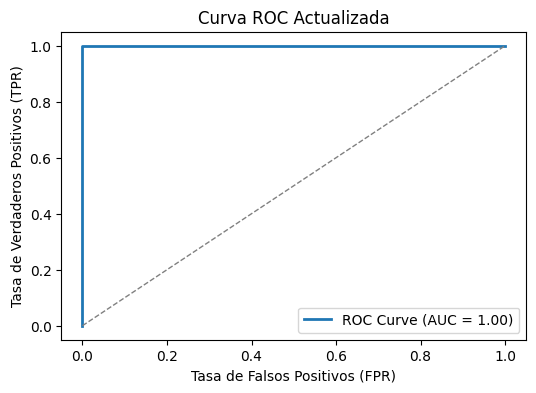

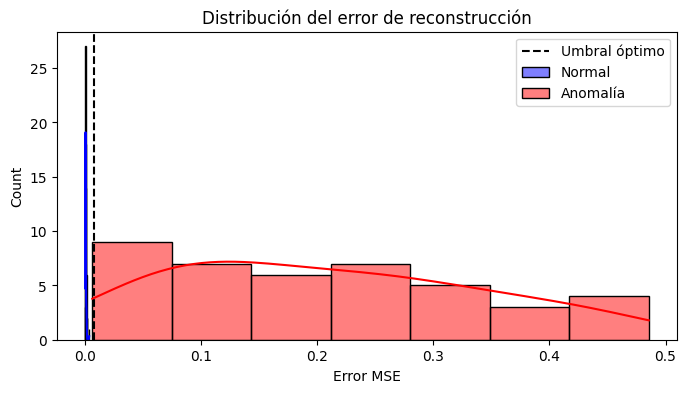

In [5]:
# Calculate metrics
y_pred = df_medical["autoencoder_anomaly"].iloc[df_test.index].values

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, mse_test)

# Show results
print(f"📊 PRECISIÓN DEL MODELO:")
print(f"✔ Precisión: {precision:.2f}")
print(f"✔ Recall (Sensibilidad): {recall:.2f}")
print(f"✔ F1-score: {f1:.2f}")
print(f"✔ ROC-AUC: {roc_auc:.2f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalía"],
            yticklabels=["Real Normal", "Real Anomalía"])

plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión Actualizada")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, mse_test)
roc_auc = roc_auc_score(y_test, mse_test)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1)

plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC Actualizada")
plt.legend()
plt.show()

# Reconstruction error distribution
plt.figure(figsize=(8, 4))
sns.histplot(mse_test[y_test == 0], color="blue", label="Normal", kde=True)
sns.histplot(mse_test[y_test == 1], color="red", label="Anomalía", kde=True)
plt.axvline(optimal_threshold, color="black", linestyle="--", label="Umbral óptimo")
plt.title("Distribución del error de reconstrucción")
plt.xlabel("Error MSE")
plt.legend()
plt.show()

**IMPROVE THE MODEL APPLYING ISOLATION FOREST AND DBSCAN**

In [6]:
# Prove that df_train and df_test only have original characteristics
features = df_train.columns
df_test_filtered = df_test[features]

# Apply Isolation Forest (trained with normal data)
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(df_train)

# Apply the model to test data
df_test["isolation_anomaly"] = iso_forest.predict(df_test_filtered) == -1  # -1 indicates an abnormality

# Apply DBSCAN
scaler = StandardScaler()
df_test_scaled = scaler.fit_transform(df_test_filtered)

dbscan = DBSCAN(eps=1, min_samples=5)  # Ajust to improve precision
df_test["dbscan_cluster"] = dbscan.fit_predict(df_test_scaled)
df_test["dbscan_anomaly"] = df_test["dbscan_cluster"] == -1  # -1 indicates an abnormality

df_test["autoencoder_anomaly"] = df_medical.loc[df_test.index, "autoencoder_anomaly"]

# Final abnormality if at least two models identify it
df_test["final_anomaly"] = (
    (df_test["autoencoder_anomaly"] + df_test["isolation_anomaly"] + df_test["dbscan_anomaly"]) >= 2
)

# Convert into integers
df_test["isolation_anomaly"] = df_test["isolation_anomaly"].astype(int)
df_test["dbscan_anomaly"] = df_test["dbscan_anomaly"].astype(int)
df_test["final_anomaly"] = df_test["final_anomaly"].astype(int)


📊 PRECISIÓN MEJORADA DEL MODELO:
✔ Precisión: 1.00
✔ Recall (Sensibilidad): 0.95
✔ F1-score: 0.97
✔ ROC-AUC: 1.00


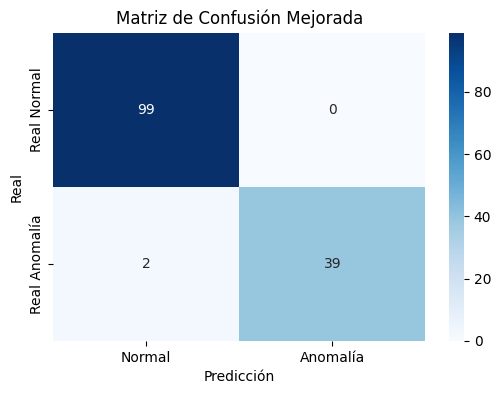

In [7]:
# Calculate metrics
precision = precision_score(y_test, df_test["final_anomaly"])
recall = recall_score(y_test, df_test["final_anomaly"])
f1 = f1_score(y_test, df_test["final_anomaly"])
roc_auc = roc_auc_score(y_test, mse_test)

# Show results
print(f"📊 PRECISIÓN MEJORADA DEL MODELO:")
print(f"✔ Precisión: {precision:.2f}")
print(f"✔ Recall (Sensibilidad): {recall:.2f}")
print(f"✔ F1-score: {f1:.2f}")
print(f"✔ ROC-AUC: {roc_auc:.2f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, df_test["final_anomaly"])

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalía"], yticklabels=["Real Normal", "Real Anomalía"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión Mejorada")
plt.show()

Now, the next risk prediction model is different from Autoencoders, Isolation Forest, and DBSCAN (unsupervised learning). Instead of detecting anomalies based on deviations, it learns from the predictions of those methods using supervised learning.

✅ **Benefits of this model:**

*Supervised learning from combined anomaly detection methods:*
It improves anomaly detection by learning patterns from previous predictions.

*Generalization and reusability:*
Once trained, it can be used on new patients without recalibrating Autoencoder or Isolation Forest.

*Enhances precision by combining multiple models:*
Instead of relying on a single method, it integrates multiple signals.

*Can be deployed in clinical settings:*
It provides a risk score (0 to 1) for anomaly detection.

*Can continuously improve:*
The model can be retrained with new data to enhance its accuracy.

<ipython-input-33-e96fde5cb65b>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df_medical.groupby("final_anomaly", group_keys=False).apply(lambda x: x.sample(min(len(x), 100)))
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📊 Informe del modelo supervisado de riesgo (balanceado):
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       100
           1       0.83      0.87      0.85        39

    accuracy                           0.91       139
   macro avg       0.89      0.90      0.89       139
weighted avg       0.92      0.91      0.91       139



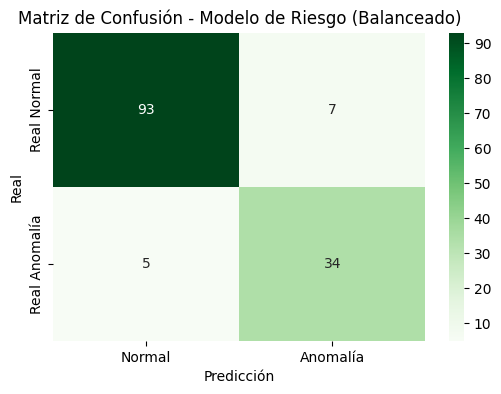

In [33]:
from sklearn.metrics import classification_report
from tensorflow.keras.layers import BatchNormalization

for col in ["autoencoder_anomaly", "isolation_anomaly", "dbscan_anomaly", "final_anomaly"]:
    if col not in df_medical.columns:
        df_medical[col] = 0  # Inicializar con 0 por si hay valores que no estén en df_test
    df_medical.loc[df_test.index, col] = df_test[col]

# Balance data
df_balanced = df_medical.groupby("final_anomaly", group_keys=False).apply(lambda x: x.sample(min(len(x), 100)))
X_balanced = df_scaled.loc[df_balanced.index]
y_balanced = df_balanced["final_anomaly"]

# Define the model
risk_model = keras.Sequential([
    keras.layers.Dense(128, activation="relu", input_shape=(X_balanced.shape[1],)),
    BatchNormalization(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(64, activation="relu"),
    BatchNormalization(),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

# Train the model
risk_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
risk_model.fit(X_balanced, y_balanced, epochs=30, batch_size=10, verbose=0)

y_scores = risk_model.predict(X_balanced).flatten()
fpr, tpr, thresholds = roc_curve(y_balanced, y_scores)
optimal_idx = np.argmax(tpr - fpr)  # Encuentra el mejor punto
optimal_threshold = thresholds[optimal_idx]*1.2  # Establece el umbral óptimo

y_pred_balanced = (y_scores > optimal_threshold).astype(int)

# Show classification_report
print("📊 Informe del modelo supervisado de riesgo (balanceado):")
print(classification_report(y_balanced, y_pred_balanced))

# Confusion matrix
conf_matrix = confusion_matrix(y_balanced, y_pred_balanced)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Normal", "Anomalía"], yticklabels=["Real Normal", "Real Anomalía"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Modelo de Riesgo (Balanceado)")
plt.show()



In [34]:
from sklearn.preprocessing import MinMaxScaler
import ipywidgets as widgets
from IPython.display import display

# Load the model
modelo_supervisado = risk_model

# Create widgets to introduce medical data
heart_rate = widgets.FloatText(value=75, description="Frecuencia cardíaca:")
spo2 = widgets.FloatText(value=97, description="SpO2 (%):")
temperature = widgets.FloatText(value=36.6, description="Temperatura (°C):")
glucose = widgets.FloatText(value=90, description="Glucosa (mg/dL):")

btn_predict = widgets.Button(description="Analizar Salud")

# Show fields
display(heart_rate, spo2, temperature, glucose, btn_predict)

# Normalize
scaler = MinMaxScaler()
scaler.fit([[65, 95, 36.1, 75],  # Min values expected
            [85, 100, 37.1, 105]])  # Max values expected

# Function to process data and make a prediction
def analizar_paciente(b):
    # Values introduced by the user
    datos_usuario = np.array([[heart_rate.value, spo2.value, temperature.value, glucose.value]])

    # Normalize data
    datos_usuario_normalizados = scaler.transform(datos_usuario)

    # Make the prediction
    prediccion = modelo_supervisado.predict(datos_usuario_normalizados)[0][0]

    # Interpret the result applying a threshold
    resultado = "🚨 ¡Posible Anomalía Detectada! 🚨" if prediccion > 0.5 else "✅ Estado de Salud Normal ✅"

    print(f"\n🔍 Resultado del Análisis: {resultado} (Score: {prediccion:.2f})")

# Link the button to the function
btn_predict.on_click(analizar_paciente)


FloatText(value=75.0, description='Frecuencia cardíaca:')

FloatText(value=97.0, description='SpO2 (%):')

FloatText(value=36.6, description='Temperatura (°C):')

FloatText(value=90.0, description='Glucosa (mg/dL):')

Button(description='Analizar Salud', style=ButtonStyle())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
🔎 Debug - Predicción sin redondeo: 0.39

🔍 Resultado del Análisis: ✅ Estado de Salud Normal ✅ (Score: 0.39)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
🔎 Debug - Predicción sin redondeo: 0.72

🔍 Resultado del Análisis: 🚨 ¡Posible Anomalía Detectada! 🚨 (Score: 0.72)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
🔎 Debug - Predicción sin redondeo: 0.44

🔍 Resultado del Análisis: ✅ Estado de Salud Normal ✅ (Score: 0.44)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
🔎 Debug - Predicción sin redondeo: 0.66

🔍 Resultado del Análisis: 🚨 ¡Posible Anomalía Detectada! 🚨 (Score: 0.66)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
🔎 Debug - Predicción sin redondeo: 0.80

🔍 Resultado del Análisis: 🚨 ¡Posible Anomalía Detectada! 🚨 (Score: 0.80)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
🔎 Debug - Predicción sin redondeo: 0.44

🔍 Resultado del Análisis: ✅ Estado de Salud Normal ✅ (Score: 0.44)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
🔎 Debug - Predicción sin redondeo: 0.22

🔍 Resultado del Análisis: ✅

Now we will use LSTM (Long Short-Term Memory), a recurrent neural network (RNN) that analyzes medical data over time.

📌 What does this improve?

✅ Uses historical data → Analyzes medical trends over time.

✅ Predicts if a patient will develop an anomaly in the future → Based on past data.

✅ More useful for clinical applications → Helps anticipate medical risks.

In [106]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Layer, Multiply, Softmax, Permute, Lambda, Dropout
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

import matplotlib.pyplot as plt
import seaborn as sns

# Generate temporal simulated data (60 days)
np.random.seed(42)
num_pacientes = 500
timesteps = 60

historical_data = []
labels = []

for i in range(num_pacientes):
    paciente_id = f"P{str(i).zfill(3)}"

    # Create historical data for each patient
    heart_rate = np.random.normal(75, 10, timesteps)
    spo2 = np.random.normal(97, 2, timesteps)
    temperature = np.random.normal(36.6, 0.5, timesteps)
    systolic_bp = np.random.normal(120, 15, timesteps)
    diastolic_bp = np.random.normal(80, 10, timesteps)
    glucose = np.random.normal(90, 15, timesteps)
    bmi = np.random.normal(25, 5, timesteps)

    # Real label (1 if there is an abnormality in the lasts days)
    label = 0
    if np.random.rand() < 0.2:  # 20% of abnormalities
        idx = np.random.randint(40, 60)  # Abnormalities in last 20 days
        for j in range(idx, timesteps):  # Progressive change
            heart_rate[j] += np.random.choice([-30, 50])
            glucose[j] += np.random.choice([-40, 100])
            spo2[j] -= np.random.choice([5, 10])
        label = 1  # Mark as abnormalitie

    # Save data
    for t in range(timesteps):
        historical_data.append([paciente_id, t, heart_rate[t], spo2[t], temperature[t], systolic_bp[t], diastolic_bp[t], glucose[t], bmi[t]])

    labels.append(label)

# Convert into a dataframe
df_timeseries = pd.DataFrame(historical_data, columns=[
    "patient_id", "day", "heart_rate", "spo2", "temperature", "systolic_bp", "diastolic_bp", "glucose", "bmi"
])
df_labels = pd.DataFrame({"patient_id": [f"P{str(i).zfill(3)}" for i in range(num_pacientes)], "label": labels})

# Normalize data
scaler = MinMaxScaler()
df_timeseries.iloc[:, 2:] = scaler.fit_transform(df_timeseries.iloc[:, 2:])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.7854 - loss: 0.6558 - val_accuracy: 0.7800 - val_loss: 0.5345
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.7830 - loss: 0.5303 - val_accuracy: 0.7800 - val_loss: 0.5319
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.7692 - loss: 0.5431 - val_accuracy: 0.7800 - val_loss: 0.5312
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.7892 - loss: 0.5181 - val_accuracy: 0.7800 - val_loss: 0.5279
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.7718 - loss: 0.5386 - val_accuracy: 0.7800 - val_loss: 0.5276
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.7657 - loss: 0.5436 - val_accuracy: 0.7800 - val_loss: 0.5273
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.7694 - loss: 0.5451 - val_accuracy: 0.7800 - val_loss: 0.5269
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.7977 - loss: 0.5064 - val_accuracy: 0.7800

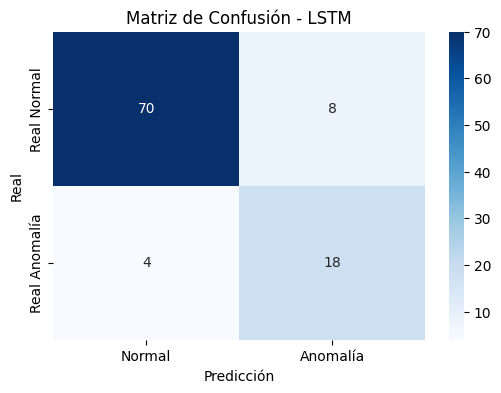

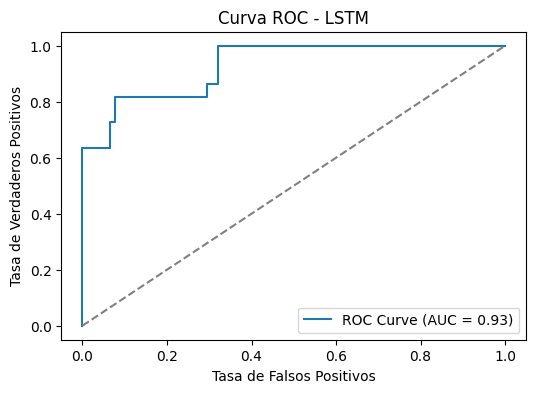

In [107]:
# Prepare data for LSTM
X_data = []
y_data = []

for patient in df_timeseries["patient_id"].unique():
    patient_data = df_timeseries[df_timeseries["patient_id"] == patient].iloc[:, 2:].values
    label = df_labels[df_labels["patient_id"] == patient]["label"].values[0]

    X_data.append(patient_data[:-1])  # Use the first 59 days
    y_data.append(label)  # Binary prediction (0: Normal, 1: Abnormality)

X_data = np.array(X_data)
y_data = np.array(y_data)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, stratify=y_data, random_state=42)

# Define improved attention layer
class Attention(Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(1,), initializer="zeros", trainable=True)

    def call(self, inputs):
        score = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        attention_weights = tf.nn.softmax(score, axis=1)
        return Multiply()([inputs, attention_weights])

# Define the LSTM model with binary prediction
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32, return_sequences=True),
    Attention(),  # Attention layer
    LSTM(16, return_sequences=False),
    Dense(1, activation="sigmoid")
])

lstm_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
lstm_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), shuffle=True, verbose=1)

# Make predictions
y_pred_proba = lstm_model.predict(X_test).flatten()
y_pred = (y_pred_proba > 0.35).astype(int)  # Convert into binary values

# Evaluate the model
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"📊 Evaluación del modelo LSTM:")
print(f"✔ Precisión: {precision:.2f}")
print(f"✔ Recall (Sensibilidad): {recall:.2f}")
print(f"✔ F1-score: {f1:.2f}")
print(f"✔ ROC-AUC: {roc_auc:.2f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalía"], yticklabels=["Real Normal", "Real Anomalía"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - LSTM")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC - LSTM")
plt.legend()
plt.show()